# FANFICTION SENTIMENT ANALYSIS

## Table of Contents
* [Introduction](#one)
* [Environment setup](#two)
* [Data setup](#three)
* [Exploratory analysis](#four)
* [Building a genre classifier](#five)
    * [Feature engineering](#a)
    * [Continuous vector](#b)
* [Clustering](#six)
    * [Word choice](#c)
    * [Subject](#d)
    * [Contextual](#e)
* [Conclusion](#seven)   

# Introduction

In this notebook, we will be examining the sentiment and emotions of online fanfiction publications. 

Our goal is two-fold.

First, we would like to see if we can predict the genre of a story based on its text.

Second, we would like to examine the emotional composition of each genre.

In [282]:
# imports libraries
import pickle										# import/export lists
import datetime										# dates
import string										# string parsing
import re 											# regular expression
import pandas as pd									# dataframes
import numpy as np									# numerical computation
import matplotlib.pyplot as plt						# plot graphics
import seaborn as sns								# graphics supplemental
from scipy.stats import chisquare					# chi-squared
from IPython.core.display import display, HTML		# display HTML
from joblib import Parallel, delayed
import multiprocessing
import warnings
import xgboost as xgb

# import graphics
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib.colors import ListedColormap
%matplotlib inline

# import sklearn tools
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.decomposition import PCA, SparsePCA, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.preprocessing import scale, Binarizer, Normalizer
from sklearn.manifold import TSNE
from sklearn import metrics
from sklearn.metrics import silhouette_score
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_score

# import nltk tools
import nltk
from nltk import tokenize
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# import gensim tools
from gensim import corpora, models 
from gensim.models.coherencemodel import CoherenceModel
from gensim.test.utils import common_corpus
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

# import textblob
from textblob import TextBlob, Blobber
from textblob.sentiments import NaiveBayesAnalyzer, PatternAnalyzer

# stanford NLP
from pycorenlp import StanfordCoreNLP
stanford = StanfordCoreNLP('http://localhost:9000')

In [283]:
# configure graphics (taken from session notes)
dark2_colors = [(0.10588235294117647, 0.6196078431372549, 0.4666666666666667),
                (0.9058823529411765, 0.1607843137254902, 0.5411764705882353),
                (0.8509803921568627, 0.37254901960784315, 0.00784313725490196),
                (0.4588235294117647, 0.4392156862745098, 0.7019607843137254),
                (0.4, 0.6509803921568628, 0.11764705882352941),
                (0.9019607843137255, 0.6705882352941176, 0.00784313725490196),
                (0.6509803921568628, 0.4627450980392157, 0.11372549019607843)]
dark2_cmap = ListedColormap(dark2_colors)
def set_mpl_params():
    rcParams['figure.figsize'] = (12, 6)
    rcParams['figure.dpi'] = 100
    rcParams['axes.prop_cycle'].by_key()['color'][1]
    rcParams['lines.linewidth'] = 2
    rcParams['axes.facecolor'] = 'white'
    rcParams['font.size'] = 14
    rcParams['patch.edgecolor'] = 'white'
    rcParams['patch.facecolor'] = dark2_colors[0]
    rcParams['font.family'] = 'StixGeneral'
mpl.rcParams.update(mpl.rcParamsDefault)
set_mpl_params()
mpl.style.use('ggplot')

In [321]:
def plot_breakdown(x, title, r=90, hide=False):
    plt.rcParams['figure.figsize'] = [16, 3]
    plt.bar(range(len(x)), x)
    plt.xticks(range(len(x)), x.index, rotation=r)
    if hide:
        plt.tick_params(axis='x', bottom=False, labelbottom=False)
    plt.title(title)
    plt.show()

def plot_silhouette(x, y, title="Silhouette vs. k"):
    plt.rcParams['figure.figsize'] = [16, 2]    
    plt.plot(x, y)
    plt.scatter(x, y)
    plt.title(title)
    plt.show()
    
# plot t-sne scatter with colored groups 
def plot_representation(matrix, group, title, alpha=0.5):
    tsne_model = TSNE(n_components=2)
    tsne_matrix = tsne_model.fit_transform(matrix)
    tsne_df = pd.DataFrame(tsne_matrix)
    tsne_df.columns = ["Dimension 1", "Dimension 2"]
    tsne_df['group'] = group
    fig = sns.lmplot('Dimension 1', 'Dimension 2', 
                     data=tsne_df, hue="group", fit_reg=False, 
                     scatter_kws={'alpha':0.5}, legend=False)
    fig.fig.set_size_inches(16, 9)
    plt.title(title)
    plt.legend(loc='right', ncol=1)
    plt.show()
    
# plot by play and act-scene
def plot_scenes(data, group, outlier=False):
    data = data.copy()
    data.columns = ['label', 'y', 'x']
    data['group'] = group
    data['counts'] = data.shape[0] / data['group'].map(data['group'].value_counts())
    data['counts'] = (data['counts'] / np.max(data['counts'])) * 100
    if outlier:
        data['counts'] = [100 if g==-1 else 30 for g in group]
    plt.rcParams['figure.figsize'] = [16, 12]    
    plt.scatter(data['x'], data['y'], s=data['counts'], c=data['group'], cmap=plt.get_cmap('tab20'))
    plt.yticks(range(len(sorted(list(set(data['label']))))), sorted(list(set(data['label']))))
    plt.xticks([])
    plt.ylabel('')
    plt.xlabel('')
    plt.show()

# create custom tokenizer that includes stemmer
def custom_tokenize(text):
    tokenizer = RegexpTokenizer(r'\w+')
    stemmer = SnowballStemmer('english')
    tokens = tokenizer.tokenize(text) 
    tokens = [stemmer.stem(w) for w in tokens]
    tokens = [t for t in tokens if t not in stop_words]
    return tokens

# turn bodies of text into word count vectors
def get_word_count(vectorizer, text):
    count = vectorizer.fit_transform(text)
    count = pd.DataFrame(count.toarray())
    count.columns = vectorizer.get_feature_names()
    return count

# get the top words across all observations
def get_top_words(count, n_top):
    total_count = np.sum(count, axis=0)
    sorted_index = np.flip(np.argsort(total_count), axis=0)
    sorted_index = np.array(sorted_index[0:n_top])
    top_words = np.array(count.columns)[sorted_index]
    top_words_count = np.array(total_count)[sorted_index]
    return top_words, top_words_count

def get_pca(x, n=100):
    pca_model = PCA(n_components=n, random_state=0)
    pca_matrix = pca_model.fit_transform(scale(x))
    print("Explained variance: ", np.sum(pca_model.explained_variance_ratio_))
    return pca_matrix

def get_lsa(x, n=100):
    lsa_model = TruncatedSVD(n_components=n)
    doc_matrix = lsa_model.fit_transform(x)
    term_matrix = lsa_model.components_
    topic_matrix = np.diag(lsa_model.singular_values_)
    print("Explained variance: ", np.sum(lsa_model.explained_variance_ratio_))
    return doc_matrix, term_matrix, topic_matrix

def get_doc2vec(x, n=25):
    d2v_model = Doc2Vec(vector_size=n, min_count=1, window=5, workers=7, dm=1)
    d2v_model.build_vocab(x)
    d2v_model.train(x, total_examples=d2v_model.corpus_count, epochs=10)
    
    return d2v_model

In [3]:
# installs corpus
## nltk.download()
## nltk.download('punkt')
## nltk.download('vader_lexicon')
## nltk.download('movie_reviews')

# sets stop word list for text parsing
stop_words = stopwords.words('english')

In [221]:
# opens cleaned data
with open ('../data/clean_data/df_story', 'rb') as fp:
    df = pickle.load(fp)
df = df.loc[(df.state == 'online') & (df.language == 'English'), ].copy()
df.index = range(df.shape[0])

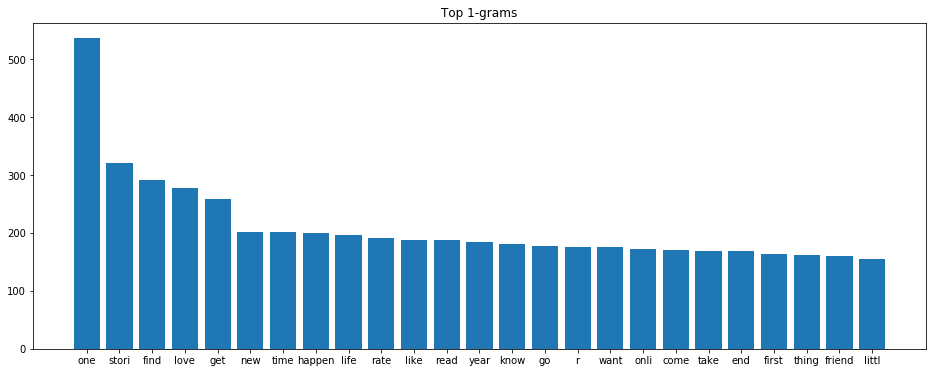

In [5]:
# get grams of text
onegram_vectorizer = CountVectorizer(tokenizer=custom_tokenize,
                                     ngram_range=(1,1),
                                     max_features=50)
text_onegram = get_word_count(onegram_vectorizer, df.summary)

# get top words
top_words, top_wc = get_top_words(text_onegram, n_top=25)

# plot top words
fig, ax = plt.subplots(figsize=(16, 6))
plt.bar(top_words,top_wc)
plt.xticks(range(len(top_words)),top_words)
plt.title("Top 1-grams")
plt.show()

## Representation of text

In [6]:
# create vectorizers that converts text to weighted ngrams
get_tfidf = TfidfVectorizer(
    tokenizer=custom_tokenize,
    sublinear_tf=True,
    strip_accents='unicode',
    analyzer='word',
    token_pattern=r'\w+',
    ngram_range=(1,2),
    max_features=5000)

# get all weighted one and two grams of titles
text_tfidf = get_word_count(get_tfidf, df.summary)

In [311]:
n_lsa = 50
lsa_docm_text, lsa_termm_text, lsa_topicm_text = get_lsa(text_tfidf, n=n_lsa)

Explained variance:  0.11714948122240915


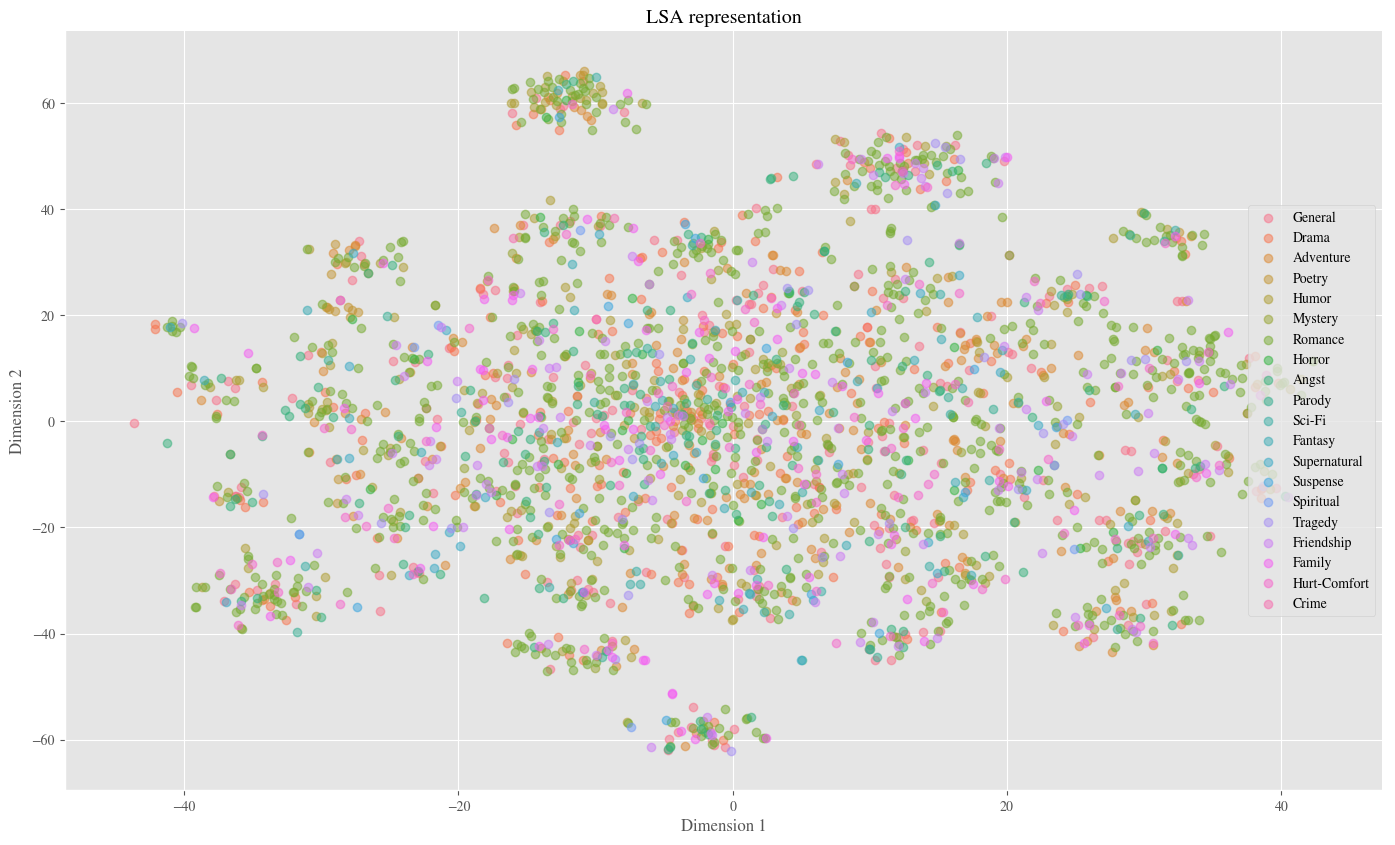

In [317]:
plot_representation(lsa_docm_text, df['main_genre'], 'LSA representation')

In [322]:
tagged_text = [TaggedDocument(words=custom_tokenize(t), tags=[str(i)]) 
                for i, t in enumerate(df.summary)]

n_d2v = 20
d2v_text = get_doc2vec(tagged_text, n_d2v)

d2v_docm_text = d2v_text.docvecs.vectors_docs

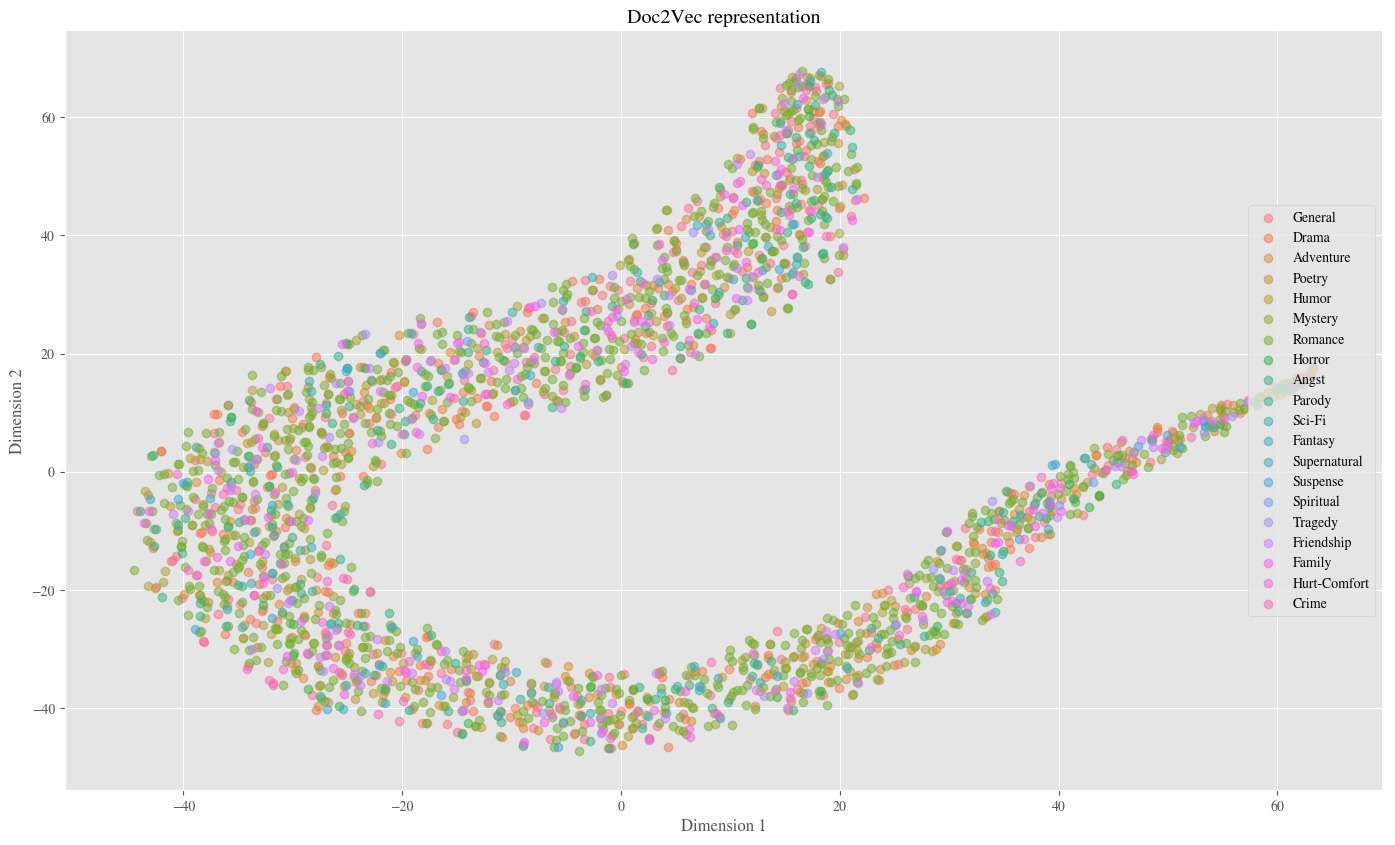

In [319]:
plot_representation(d2v_docm_text, df['main_genre'], 'Doc2Vec representation')

## Sentiment analysis

In [15]:
sia = SentimentIntensityAnalyzer()
sia_scores = []
for s in df.summary:
    sia_scores.append(sia.polarity_scores(s))

In [222]:
df['sia_pos'] = [s['pos'] for s in sia_scores]
df['sia_neg'] = [s['neg'] for s in sia_scores]
df['sia_neu'] = [s['neu'] for s in sia_scores]
df['sia_compound'] = [s['compound'] for s in sia_scores]

In [223]:
df['main_genre'] = [g[0] for g in df.genre]

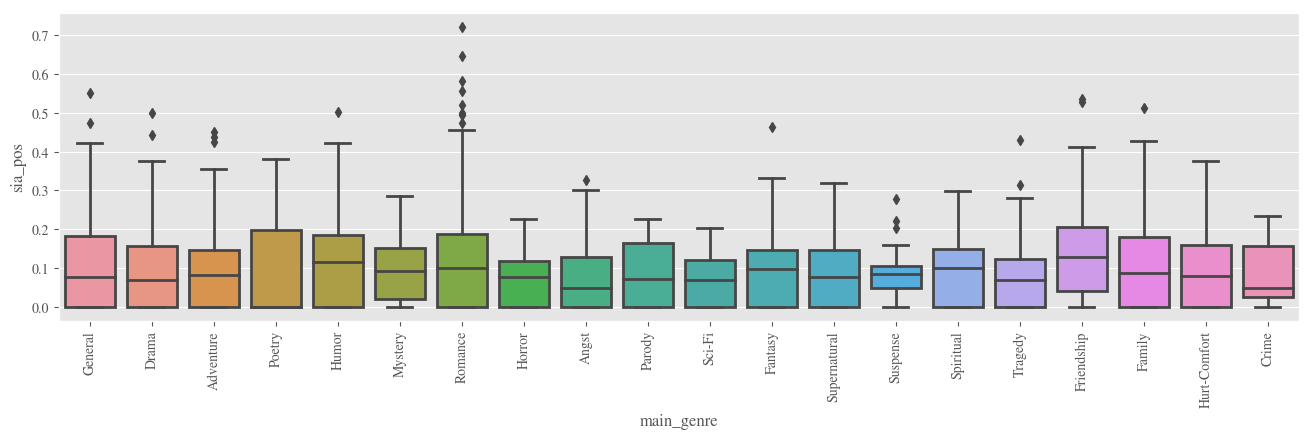

In [328]:
fig, ax = plt.subplots(figsize=(16, 4))
ax = sns.boxplot(x="main_genre", y="sia_pos", data=df)
plt.xticks(rotation=90)
plt.show()

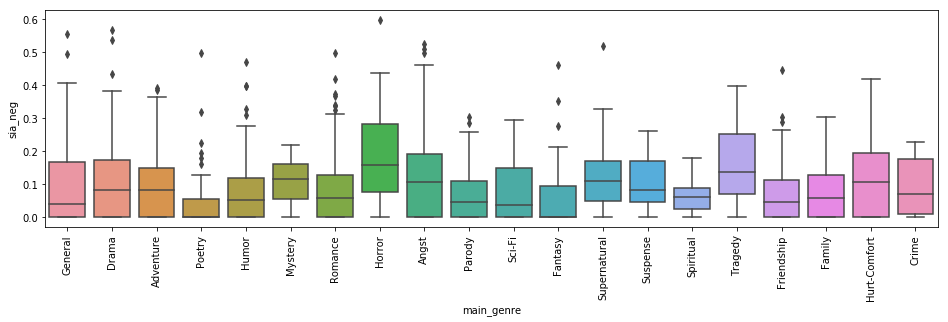

In [59]:
fig, ax = plt.subplots(figsize=(16, 4))
ax = sns.boxplot(x="main_genre", y="sia_neg", data=df)
plt.xticks(rotation=90)
plt.show()

In [54]:
nba = Blobber(analyzer=NaiveBayesAnalyzer())
pa = Blobber(analyzer=PatternAnalyzer())

def get_blob(s):
    return nba(s).sentiment, pa(s).sentiment

num_cores = multiprocessing.cpu_count()
blob_scores = Parallel(n_jobs=num_cores)(delayed(get_blob)(s) for s in df.summary)

In [224]:
df['blob_pos'] = [s[0].p_pos for s in blob_scores]
df['blob_pol'] = [s[1].polarity for s in blob_scores]
df['blob_sub'] = [s[1].subjectivity for s in blob_scores]

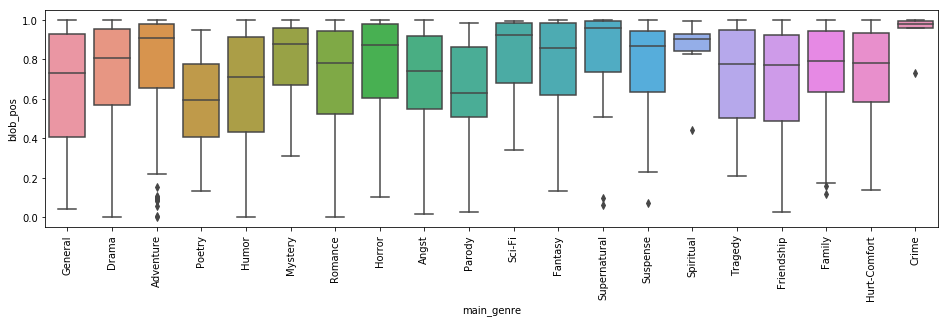

In [60]:
fig, ax = plt.subplots(figsize=(16, 4))
ax = sns.boxplot(x="main_genre", y="blob_pos", data=df)
plt.xticks(rotation=90)
plt.show()

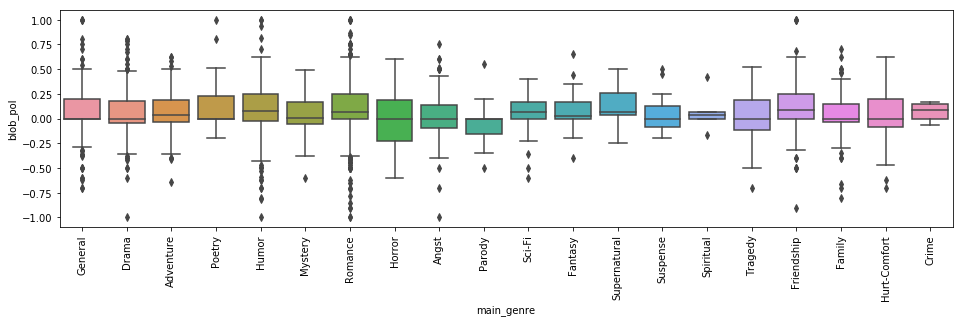

In [61]:
fig, ax = plt.subplots(figsize=(16, 4))
ax = sns.boxplot(x="main_genre", y="blob_pol", data=df)
plt.xticks(rotation=90)
plt.show()

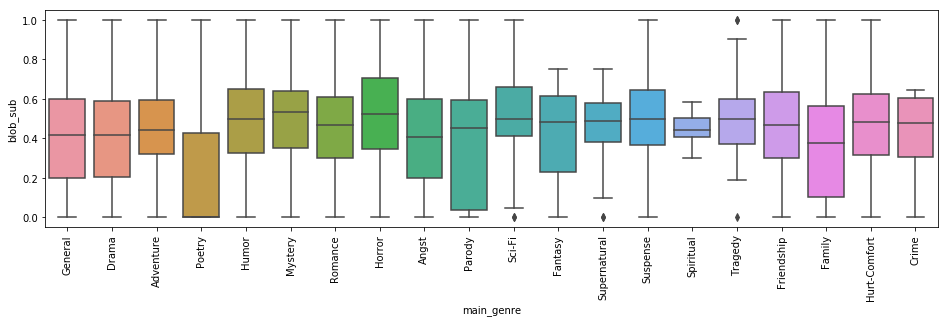

In [62]:
fig, ax = plt.subplots(figsize=(16, 4))
ax = sns.boxplot(x="main_genre", y="blob_sub", data=df)
plt.xticks(rotation=90)
plt.show()

In [122]:
# java -mx1g -cp "*" edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 25000

stanford_scores = []
for s in df.summary:
    s = re.sub('[\[\]]+', '', s)
    result = stanford.annotate(s,
                               properties={
                                'annotators': 'sentiment',
                                'outputFormat': 'json',
                                'timeout': '10000'
                               })
    for r in result['sentences']:
        score = (r['sentimentValue'], r['sentimentDistribution'])
    stanford_scores.append(score)

In [225]:
df['stanford_score'] = [int(g[0]) for g in stanford_scores]
df['stanford_s1'] = [g[1][0] for g in stanford_scores]
df['stanford_s2'] = [g[1][1] for g in stanford_scores]
df['stanford_s3'] = [g[1][2] for g in stanford_scores]
df['stanford_s4'] = [g[1][3] for g in stanford_scores]
df['stanford_s5'] = [g[1][4] for g in stanford_scores]

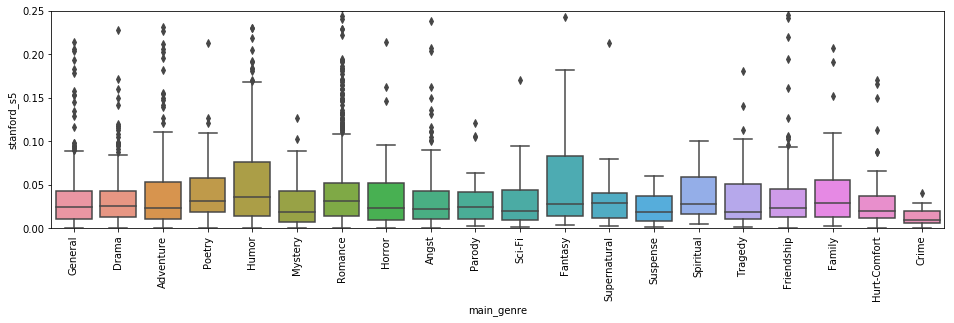

In [135]:
fig, ax = plt.subplots(figsize=(16, 4))
ax = sns.boxplot(x="main_genre", y="stanford_s5", data=df)
plt.xticks(rotation=90)
plt.ylim(0, 0.25)
plt.show()

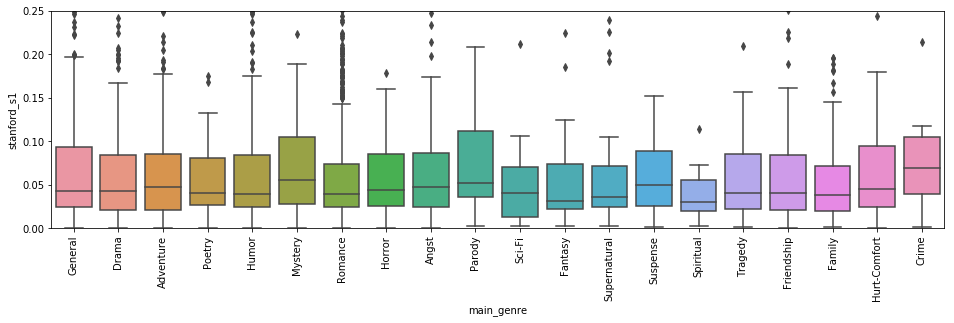

In [134]:
fig, ax = plt.subplots(figsize=(16, 4))
ax = sns.boxplot(x="main_genre", y="stanford_s1", data=df)
plt.xticks(rotation=90)
plt.ylim(0, 0.25)
plt.show()

In [137]:
df.to_pickle("../data/clean_data/df_sentiment")

## XGBoost multiclass classification

In [323]:
colnames = ['storyid', 'words', 'sia_pos', 'sia_neg', 'sia_neu', 'sia_compound', 
            'blob_pos', 'blob_pol', 'blob_sub', 
            'stanford_s1', 'stanford_s2', 'stanford_s4', 'stanford_s5'] 

X = df[colnames]
X['storyid'] = X['storyid'].astype('int')
X[['LSA' + str(i) for i in range(n_lsa)]] = pd.DataFrame(lsa_docm_text)
X[['D2V' + str(i) for i in range(n_d2v)]] = pd.DataFrame(d2v_docm_text)

Y = df['main_genre'].factorize()[0]

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=2016)
#y_train = np.array(y_train).ravel()
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(1691, 83) (834, 83) (1691,) (834,)


In [324]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

In [325]:
param = {
    'max_depth': 3,  # the maximum depth of each tree
    'eta': 0.3,  # the training step for each iteration
    'silent': 1,  # logging mode - quiet
    'objective': 'multi:softprob',  # error evaluation for multiclass training
    'num_class': len(np.unique(y_train))}  # the number of classes that exist in this datset
num_round = 20  # the number of training iterations

bst = xgb.train(param, dtrain, num_round)
preds = bst.predict(dtest)

In [326]:
best_preds = np.asarray([np.argmax(line) for line in preds])
print(precision_score(y_test, best_preds, average='macro'))
print(accuracy_score(y_test, best_preds))

0.08640312068027031
0.3213429256594724


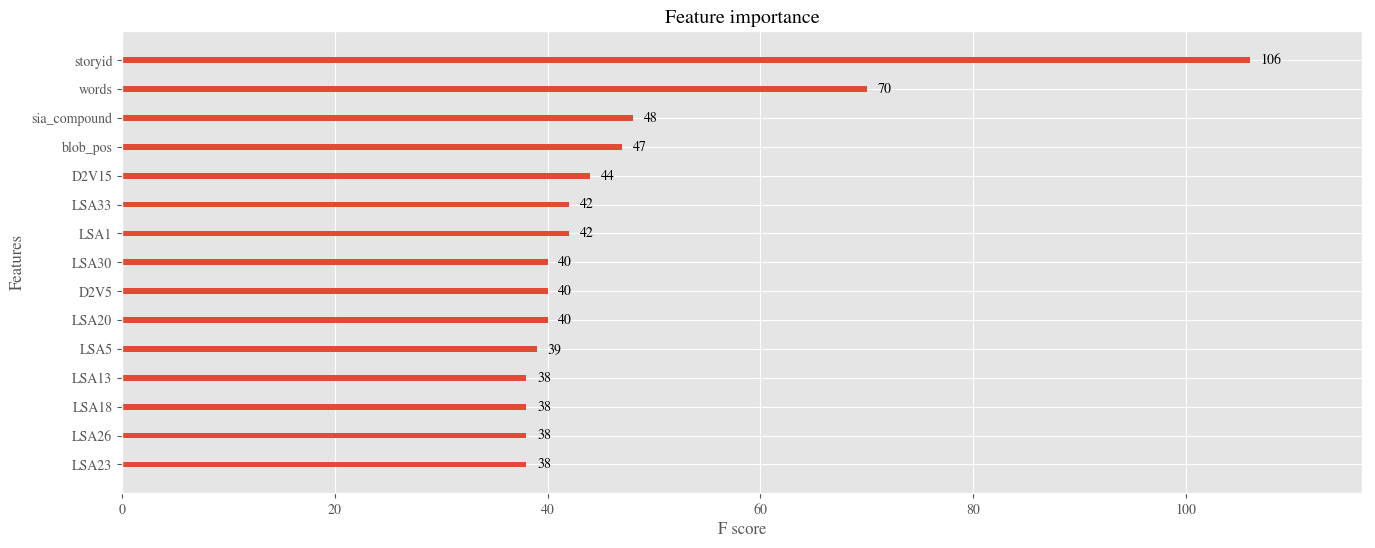

In [332]:
fig, ax = plt.subplots(figsize=(16, 6))
xgb.plot_importance(bst, ax=ax, max_num_features = 15)
plt.show()

## Genres

Now let's look at the distribution across the stories. Note that "General" includes stories that do not have a genre label.

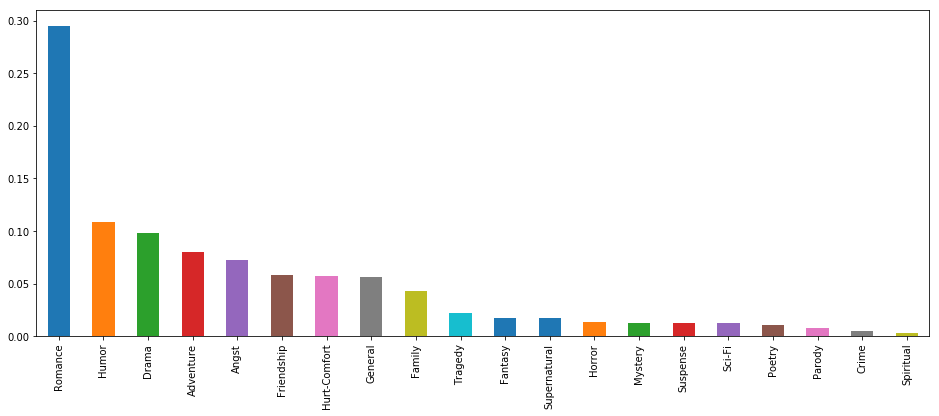

In [126]:
# examines top genres individually
genres_indiv = [item for sublist in df_online['genre'] for item in sublist]
genres_indiv = pd.Series(genres_indiv).value_counts()

# plots chart
fig, ax = plt.subplots(figsize=(16, 6))
(genres_indiv/np.sum(genres_indiv)).plot.bar()
plt.xticks(rotation=90)
plt.show()

Romance takes the lead! In fact, ~30% of the genre labels used is "Romance". In second and third place are Humor and Drama respectively.

The least popular genres appear to be Crime, Horror, and Mystery. 

So far, nothing here deviates much from intuition. We'd expect derivative works to focus more on existing character relationships and/or the canonic world, and less on stand-alone plots and twists. 

What about how the genres combine?

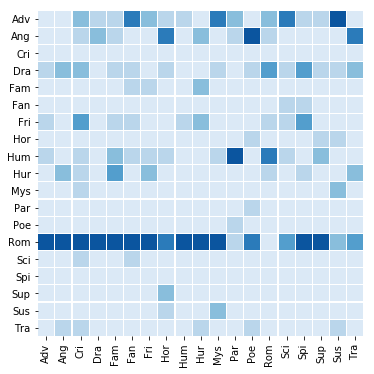

In [66]:
# creates contingency table
gen_pairs = df.loc[[len(row) > 1 for row in df.genre], 'genre']
gen1 = pd.Series([row[0][:3] for row in gen_pairs] + [row[1][:3] for row in gen_pairs])
gen2 = pd.Series([row[1][:3] for row in gen_pairs] + [row[0][:3] for row in gen_pairs])
cross = pd.crosstab(index=gen1, columns=gen2, colnames=[''])
del cross.index.name

# finds relative frequency
for col in cross.columns.values:
    cross[col] = cross[col]/np.sum(cross[col])
    
# plots heatmap
f, ax = plt.subplots(figsize=(6,6))
cm = sns.color_palette("Blues")
ax = sns.heatmap(cross, cmap=cm, cbar=False, robust=True,
                 square=True, linewidths=0.1, linecolor='white')

plt.show()

In terms of how genres cross, romance appears to pair with almost everything. Romance is particularly common with drama (the romantic drama) and humor (the rom-com). The only genre that shies away from romance is parody, which goes in hand with humor instead. 

The second most crossed genre is adventure, which is often combined with fantasy, sci-fi, mystery, or suspense. 

The third genre to note is angst, which is often combined with horror, poetry, or tragedy.

## Word count, chapter length and completion status

Let's take a look at the distribution of word and chapter lengths.

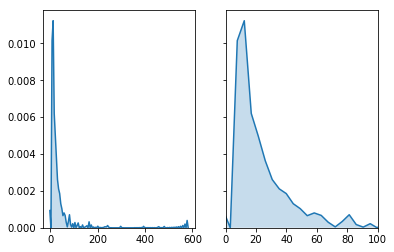

In [13]:
# examines distribution of number of words
df_online['words1k'] = df_online['words']/1000

f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
sns.kdeplot(df_online['words1k'], shade=True, bw=.5, legend=False, ax=ax1)
sns.kdeplot(df_online['words1k'], shade=True, bw=.5, legend=False, ax=ax2)
plt.xlim(0,100)

plt.show()

The bulk of stories appear to be less than 50 thousand words, with a high proportion between 0-20 thousand words. In other words, we have a significant proportion of short stories and novelettes, and some novellas. Novels become more rare. Finally, there are a few "epics", ranging from 200 thousand to 600 thousand words.

The number of chapters per story, unsurprisingly, follows a similarly skewed distribution.

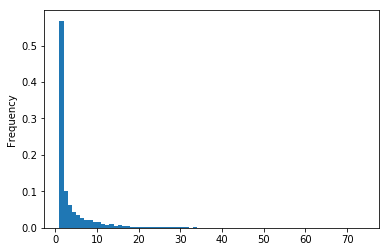

In [14]:
# examines distribution of number of chapters
df_online['chapters'] = df_online['chapters'].fillna(1)
df_online['chapters'].plot.hist(normed=True, 
                                bins=np.arange(1, max(df_online.chapters)+1, 1))

plt.show()

Stories with over 20 chapters become exceedingly rare.

How often are stories completed?

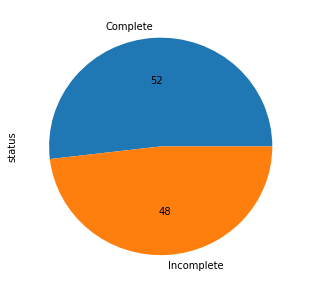

In [15]:
# examines distribution of story status
status = df_online['status'].value_counts()
status.plot.pie(autopct='%.f', figsize=(5,5))

plt.show()

This is unexpected. It looks to be about an even split between completed and incompleted stories.

Let's see what types of stories are the completed ones.

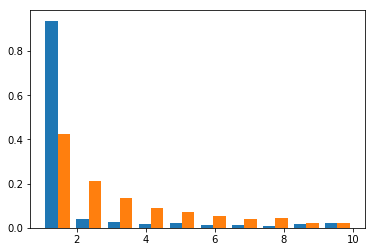

In [16]:
complete = df_online.loc[df_online.status == 'Complete', 'chapters']
incomplete = df_online.loc[df_online.status == 'Incomplete', 'chapters']

plt.hist([complete, incomplete], normed=True, range=[1,10])

plt.show()

Oneshots explain the large proportion of completed stories.

## Titles and summaries

How long are titles and summaries? Is there a systematic way authors write them? Do some words appear more often than others? Here we explore some of those questions.

Let's start by examining character and word count, respectively, for titles.

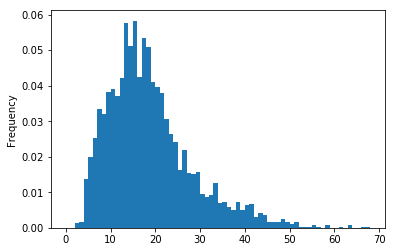

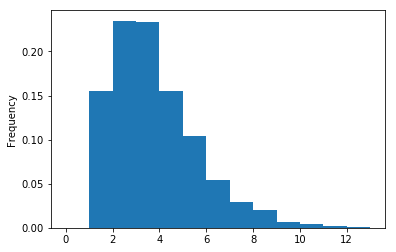

In [22]:
# examines word/character count of titles
title_cc = [len(row) for row in df_online['title']]
title_wc = [len(row.split()) for row in df_online['title']]


pd.Series(title_cc).plot.hist(normed=True, bins=np.arange(0, max(title_cc), 1))

plt.show()

pd.Series(title_wc).plot.hist(normed=True, bins=np.arange(0, max(title_wc), 1))

plt.show()

Almost identical in shape of distribution. It would appear stories typically have 2-3 words in the title, or 15-20 characters.

Now let's look at summaries.

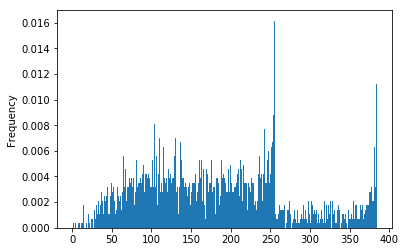

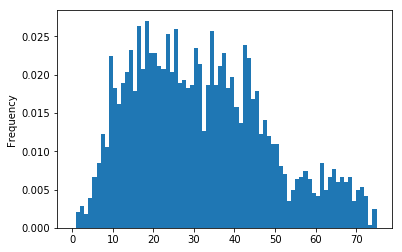

In [23]:
# examines word/character count of summaries
summary_cc = [len(row) for row in df_online['summary']]
summary_wc = [len(row.split()) for row in df_online['summary']]


pd.Series(summary_cc).plot.hist(normed=True, bins=np.arange(0, max(summary_cc), 1))

plt.show()

pd.Series(summary_wc).plot.hist(normed=True, bins=np.arange(0, max(summary_wc), 1))

plt.show()

Again, similar shapes. We can see the vestige of the original 255 character limit for summaries. Overall, it would appear summary lengths are pretty well dispersed.